In [35]:
import torch 
import torch.nn as nn
import torchvision.datasets as vision_dsets
from torch.utils import data
import torchvision.transforms as T # Transformation functions to manipulate images


def get_mnist_dataloader(root='untracked',train =True,transforms=T.ToTensor() ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = transforms,
                                    download=download)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = transforms,
                                    download=download)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return trainDataLoader,testDataLoader

trainDataLoader, testDataLoader = get_mnist_dataloader(transforms=T.Compose([T.ToTensor(), ]))

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


In [39]:
import torch 
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, model="linear"):
        super().__init__()
        self.model_type = model
        if model =="linear":
            self.linear1 = nn.Linear(784, 128)
            self.linear2 = nn.Linear(128, 10)
        elif model == "cnn":
            self.conv1 = nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=3, stride=1)	
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=28, kernel_size=3, stride=2)
            self.fc1 = nn.Linear(in_features=4032, out_features=512)
            self.fc2 = nn.Linear(in_features=512, out_features=10)
            
    def forward(self, x):
        batch_size = x.size(0)

        if self.model_type == "linear":
            x = x.view(batch_size, -1)
            x = self.linear1(x)
            x = nn.functional.relu(x)
            x = self.linear2(x) 
        else:

            x = nn.functional.relu(self.conv1(x))
            x = nn.functional.relu(self.conv2(x))
            x = x.contiguous().view(batch_size, -1)
            x = self.fc1(x)
            x = nn.functional.relu(x)
            x = self.fc2(x)
        return x 



In [40]:
linear_model = Model(model="linear").cuda()
cnn_model = Model(model="cnn").cuda()

# Todo : Cuda 

In [41]:
import torch.optim as optim
from torch.autograd import Variable


def train(net, train_loader, optimizer, criterion,  epoch=2):
    net.train()
    for e in range(epoch):
        running_loss = 0.0  
        for i, data in enumerate(train_loader, 0): 
            # get the inputs
            inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
            inputs = Variable(inputs).cuda()
            labels = Variable(labels).cuda()
            # zero the parameter gradients
            optimizer.zero_grad()    

            # forward + backward + optimize
            outputs = net(inputs) # get output after passing through the network
            loss = criterion(outputs, labels) # compute model's score using the loss function 
            loss.backward() # perform back-propagation from the loss
            optimizer.step() # perform gradient descent with given optimizer

            # print statistics
            running_loss += loss.item()
            if (i+1) % 500 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                running_loss = 0.0

criterion = nn.CrossEntropyLoss() 
models = [cnn_model]
optimizers  = [
                torch.optim.Adam(cnn_model.parameters(), lr=0.001, )]


for model, opti, in zip(models, optimizers):
    print("--- Training Started with model ---")
    print(model)
    train(model, trainDataLoader, opti, criterion, 2)


--- Training Started with model ---
Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 28, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=4032, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
[1,   500] loss: 0.316
[1,  1000] loss: 0.109
[1,  1500] loss: 0.076
[2,   500] loss: 0.043
[2,  1000] loss: 0.043
[2,  1500] loss: 0.041


In [44]:
x = trainDataLoader.dataset[10][0].clone().cuda()
y = Variable(torch.tensor(trainDataLoader.dataset[10][1])).cuda()
x_baseline = torch.ones_like(x).cuda()

def make_interpolation(x, base, M):
    lst = [] 
    for i in range(M):
        alpha = i/M
        interpolated =x * (alpha) + base * (1-alpha)
        lst.append(interpolated.clone())
    return torch.stack(lst)

X = make_interpolation(x, x_baseline, 10)
X = Variable(X, requires_grad=True) 
X.retain_grad()

y = torch.stack([y for i in range(len(X))]).cuda()


print(x.size(), x_baseline.size())
print(X.size())

output = models[0].forward(X)
loss = criterion(output, y)
loss.backward()

gradient = X.grad
print(gradient.size())

IG = (x-x_baseline) * gradient.sum(axis=0)
IG_fake = gradient.sum(axis=0)

torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


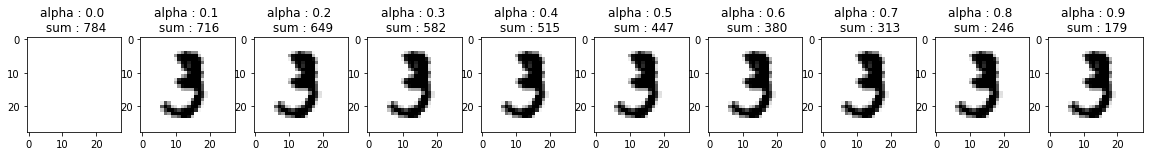

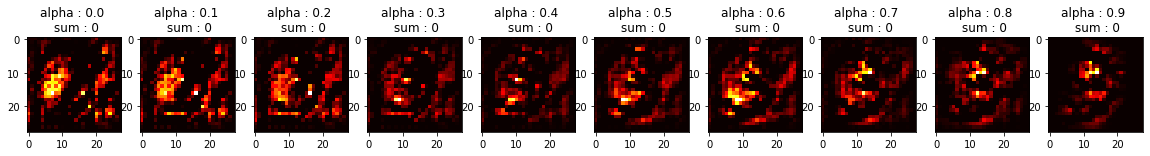

In [45]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,len(X), figsize=(20,10))
for j, img in enumerate(X):
    ax[j].imshow(img.detach().cpu().permute(1,2,0).numpy(), cmap='binary')
    ax[j].set_title(f"alpha : {j/len(X)} \n sum : " + str(int(img.sum().item())))

fig, ax = plt.subplots(1,len(gradient), figsize=(20,10))
for j, img in enumerate(gradient):
    ax[j].imshow(img.detach().permute(1,2,0).cpu().numpy().clip(0,1), cmap='hot')
    ax[j].set_title(f"alpha : {j/len(X)} \n sum : " + str(int(img.sum().item())))

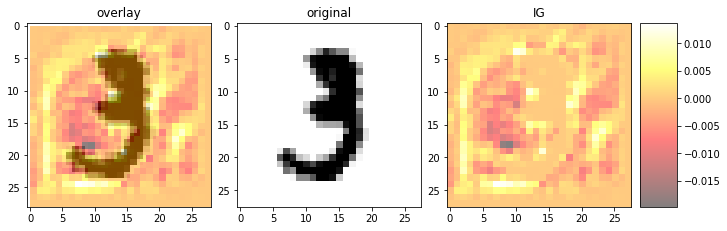

In [46]:

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(10,10))
ax[1].imshow(x.detach().cpu().permute(1,2,0), cmap='binary')
ax[2].imshow(IG.cpu().permute(1,2,0), alpha=0.5, cmap='hot')
ax[0].imshow(x.detach().cpu().permute(1,2,0), cmap='binary')
pcm = ax[0].pcolormesh(IG.cpu().sum(0), alpha=0.5, cmap='hot')
cax = ax[2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[2].transAxes)
fig.colorbar(pcm, ax=ax[2], cax=cax)

ax[0].set_title("overlay")
ax[1].set_title("original")
ax[2].set_title("IG")
plt.show()

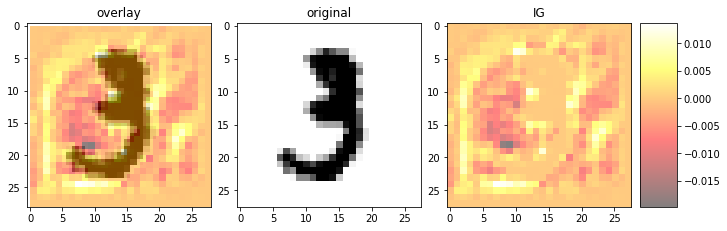

In [47]:

fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(10,10))
ax[1].imshow(x.detach().cpu().permute(1,2,0), cmap='binary')
ax[2].imshow(IG.cpu().permute(1,2,0), alpha=0.5, cmap='hot')
ax[0].imshow(x.detach().cpu().permute(1,2,0), cmap='binary')
pcm = ax[0].pcolormesh(IG.cpu().sum(0), alpha=0.5, cmap='hot')
cax = ax[2].inset_axes([1.05, 0.0, 0.2, 1.0], transform=ax[2].transAxes)
fig.colorbar(pcm, ax=ax[2], cax=cax)

ax[0].set_title("overlay")
ax[1].set_title("original")
ax[2].set_title("IG")
plt.show()